In [1]:
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt
import os
import pygrib
from copy import deepcopy
import datetime
from ipywidgets import *
import pandas as pd
import glob

In [2]:
%matplotlib inline

In [3]:
os.environ['CFLAGS']='-I/usr/local/lib/python2.7/dist-packages/numpy/core/include'

In [4]:
from meteo import wmap

In [5]:
def shiftmap(varin):

    zlon=varin.shape[1]
    varin_ = np.hstack([varin[:,zlon/2:],varin[:,0:zlon/2]])
    svarin  = varin_
    return svarin
    
def erai_parser(filename,minlon,maxlon,minlat,maxlat):
    erai=pygrib.open(filename)
    pp,uu,vv=erai[8].data()[0],erai[2].data()[0],erai[3].data()[0]
    ilat,ilon=erai[8].latlons()

    lon=ilon[0,:]
    lat=np.flipud(ilat)[:,0]

    pp=pp*.01 #convert tp hPa
    
    if minlon < 0. :
        lon=lon-180.
 
    pp=shiftmap(pp)
    uu=shiftmap(uu)
    vv=shiftmap(vv)
    i1=np.abs(lon-minlon).argmin()-2
    i2=np.abs(lon-maxlon).argmin()+2
    j1=np.abs(lat-minlat).argmin()-2
    j2=np.abs(lat-maxlat).argmin()+2
    
    pp=np.flipud(pp)
    uu=np.flipud(uu)
    vv=np.flipud(vv)

    lons, lats = np.meshgrid(lon[i1:i2],lat[j1:j2])
    p=deepcopy(pp[j1:j2,i1:i2])   
    u=deepcopy(uu[j1:j2,i1:i2])
    v=deepcopy(vv[j1:j2,i1:i2])
    
    return p,u,v,lats,lons


## Analyse wrf

In [6]:
#WRF Data
wrf=Dataset('/mnt/poseidon/INGRID_BIGGER_WINDOW/wrfout.nc')

In [7]:
# Grab these variables for now
temps =  wrf.variables['T2']
u_wind_ms = wrf.variables['U10']
v_wind_ms = wrf.variables['V10']
psfc = wrf.variables['PSFC']
T = wrf.variables['T']
times = wrf.variables['Times']

In [8]:
# x_dim and y_dim are the x and y dimensions of the model
# domain in gridpoints
x_dim = len(wrf.dimensions['west_east'])
y_dim = len(wrf.dimensions['south_north'])

# Get the grid spacing
dx = float(wrf.DX)
dy = float(wrf.DY)

width_meters = dx * (x_dim - 1)
height_meters = dy * (y_dim - 1)

cen_lat = float(wrf.CEN_LAT)
cen_lon = float(wrf.CEN_LON)
truelat1 = float(wrf.TRUELAT1)
truelat2 = float(wrf.TRUELAT2)
standlon = float(wrf.STAND_LON)
#truelat1 = float(60)
#truelat2 = float(10)



In [9]:
minlon=wrf.variables['XLONG'][0].min()-1
maxlon=wrf.variables['XLONG'][0].max()+1
minlat=wrf.variables['XLAT'][0].min()-1
maxlat=wrf.variables['XLAT'][0].max()+1


In [10]:
minlon,maxlon,minlat,maxlat

(-106.36001586914062,
 -83.639999389648438,
 8.6400003433227539,
 31.360000610351562)

In [11]:
# define parallels and meridians to draw.
parallels = np.arange(-90.,90,5.)
meridians = np.arange(0.,360.,5.)


In [12]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat,\
             llcrnrlon=minlon,urcrnrlon=maxlon,resolution='h')


In [13]:
# This sets the standard grid point structure at full resolution
x,y = m(wrf.variables['XLONG'][0],wrf.variables['XLAT'][0])


In [14]:
# Thin factor is used for thinning out wind barbs
thin = 5

In [15]:
# Set universal figure margins
width = 10
height = 8


In [16]:
plt.ioff()
plt.figure(figsize=(width,height))
plt.rc("figure.subplot", left = .001)
plt.rc("figure.subplot", right = .999)
plt.rc("figure.subplot", bottom = .001)
plt.rc("figure.subplot", top = .999)

plt.ion()

### compute mslp for all times of WRF

In [17]:
# Convert Surface Pressure to Mean Sea Level Pressure
sts = temps+6.5*wrf.variables['HGT'][:]/1000.
p1 = wrf.variables['PSFC'][:]*np.exp(9.81/(287.0*sts)*wrf.variables['HGT'][:])*0.01 + (6.7 * wrf.variables['HGT'][:] / 1000)

In [18]:
p1.shape

(241, 149, 149)

### read all ecmwf data

In [19]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta


In [20]:
sdate=datetime.datetime.strptime(''.join(times[0]),'%Y-%m-%d_%H:%M:%S')
edate=datetime.datetime.strptime(''.join(times[-1]),'%Y-%m-%d_%H:%M:%S')


In [21]:
 
pt=[]
ut=[]
vt=[]
for date in perdelta(sdate, edate, datetime.timedelta(hours=12)):
    yyyy=date.year # this is for facilitating the folder format below
    mm=date.month
    dd=date.day
    hh=date.hour

    path='/mnt/poseidon/INGRID/OPER/WDIRA/{:04d}/{:02d}/{:02d}/'.format(yyyy,mm,dd)

    filename=path+'{:04d}{:02d}{:02d}.{:02d}.{}.grib'.format(yyyy,mm,dd,hh,'tropical_cyclone')
    nt=11
    p2,u2,v2,y2,x2 = wmap(filename,0,3*(nt+1),minlon,maxlon,minlat,maxlat)
    
    print date
    
    pt.append(p2)
    ut.append(u2)
    vt.append(v2)

  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-10 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-10 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-11 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-11 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-12 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-12 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-13 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-13 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-14 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-14 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-15 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-15 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-16 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-16 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-17 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-17 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-18 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-18 12:00:00


  0%|          | 0/36 [00:00<?, ?it/s]


meteo done
2013-09-19 00:00:00


100%|██████████| 36/36 [00:18<00:00,  1.93it/s]


meteo done
2013-09-19 12:00:00


In [22]:
pt = np.array(pt)
ut = np.array(ut)
vt = np.array(vt)

In [23]:
ptt = pt.reshape(pt.shape[0]*pt.shape[1],pt.shape[-2],pt.shape[-1])  # consolidate time frames
utt = ut.reshape(ut.shape[0]*ut.shape[1],ut.shape[-2],ut.shape[-1])  # consolidate time frames
vtt = vt.reshape(vt.shape[0]*vt.shape[1],vt.shape[-2],vt.shape[-1])  # consolidate time frames

### retrieve all of ERAI

In [24]:
path='/mnt/poseidon/INGRID/ERAI/'

pe=[]
ue=[]
ve=[]

for date in perdelta(sdate, edate+datetime.timedelta(hours=6), datetime.timedelta(hours=6)):
    
    name=(date-sdate).total_seconds()/3600.
    filename=path+'ERAI_SFC_INGRID_20130910_0000_{:03d}.grib'.format(int(name))
    
    erai=pygrib.open(filename)
    
    p3,u3,v3,y3,x3 = erai_parser(filename,minlon,maxlon,minlat,maxlat)
    
    pe.append(p3)
    ue.append(u3)
    ve.append(v3)

    print date

2013-09-10 00:00:00
2013-09-10 06:00:00
2013-09-10 12:00:00
2013-09-10 18:00:00
2013-09-11 00:00:00
2013-09-11 06:00:00
2013-09-11 12:00:00
2013-09-11 18:00:00
2013-09-12 00:00:00
2013-09-12 06:00:00
2013-09-12 12:00:00
2013-09-12 18:00:00
2013-09-13 00:00:00
2013-09-13 06:00:00
2013-09-13 12:00:00
2013-09-13 18:00:00
2013-09-14 00:00:00
2013-09-14 06:00:00
2013-09-14 12:00:00
2013-09-14 18:00:00
2013-09-15 00:00:00
2013-09-15 06:00:00
2013-09-15 12:00:00
2013-09-15 18:00:00
2013-09-16 00:00:00
2013-09-16 06:00:00
2013-09-16 12:00:00
2013-09-16 18:00:00
2013-09-17 00:00:00
2013-09-17 06:00:00
2013-09-17 12:00:00
2013-09-17 18:00:00
2013-09-18 00:00:00
2013-09-18 06:00:00
2013-09-18 12:00:00
2013-09-18 18:00:00
2013-09-19 00:00:00
2013-09-19 06:00:00
2013-09-19 12:00:00
2013-09-19 18:00:00
2013-09-20 00:00:00


In [25]:
pe = np.array(pe)
ue = np.array(ue)
ve = np.array(ve)

In [26]:
pe.shape

(41, 34, 34)

### retrieve all of HWRF

In [27]:
sdate,edate

(datetime.datetime(2013, 9, 10, 0, 0), datetime.datetime(2013, 9, 20, 0, 0))

In [28]:
hdate0=datetime.datetime(2013,9,12,6)

In [29]:
hdate1=datetime.datetime(2013,9,17,12)

In [30]:
th=[]
for date in perdelta(hdate0, hdate1, datetime.timedelta(hours=3)):
    th.append(date)

In [31]:
len(th)

42

In [32]:
path='/mnt/poseidon/INGRID/HWRF/TC/'

ph=[]
uh=[]
vh=[]
for date in perdelta(hdate0, hdate1, datetime.timedelta(hours=6)):
    print date
    folder=datetime.datetime.strftime(date,'%Y%m%d.%H')
    fnames=glob.glob(path+folder+'/*')
    fnames.sort()
    for f in fnames[:-2]:
        print '   ',f
        hwrf=pygrib.open(f)
    
        p4,y4,x4 = hwrf[1].data()
        u4=hwrf[706].data()[0]
        v4=hwrf[707].data()[0]
    
        # flip to make lats increasing
        y4 = np.flipud(y4)
        p4 = np.flipud(p4)*.01 #multiply to get hPa
        u4 = np.flipud(u4)
        v4 = np.flipud(v4)

    
        ph.append(p4)
        uh.append(u4)
        vh.append(v4)

        x4 = x4 -360. # shift to the plot window


2013-09-12 06:00:00
    /mnt/poseidon/INGRID/HWRF/TC/20130912.06/invest10l.2013091206.hwrfprs.storm.0p02.f000.grb2
    /mnt/poseidon/INGRID/HWRF/TC/20130912.06/invest10l.2013091206.hwrfprs.storm.0p02.f003.grb2
2013-09-12 12:00:00
    /mnt/poseidon/INGRID/HWRF/TC/20130912.12/invest10l.2013091212.hwrfprs.storm.0p02.f000.grb2
    /mnt/poseidon/INGRID/HWRF/TC/20130912.12/invest10l.2013091212.hwrfprs.storm.0p02.f003.grb2
2013-09-12 18:00:00
    /mnt/poseidon/INGRID/HWRF/TC/20130912.18/ten10l.2013091218.hwrfprs.storm.0p02.f000.grb2
    /mnt/poseidon/INGRID/HWRF/TC/20130912.18/ten10l.2013091218.hwrfprs.storm.0p02.f003.grb2
2013-09-13 00:00:00
    /mnt/poseidon/INGRID/HWRF/TC/20130913.00/ten10l.2013091300.hwrfprs.storm.0p02.f000.grb2
    /mnt/poseidon/INGRID/HWRF/TC/20130913.00/ten10l.2013091300.hwrfprs.storm.0p02.f003.grb2
2013-09-13 06:00:00
    /mnt/poseidon/INGRID/HWRF/TC/20130913.06/ten10l.2013091306.hwrfprs.storm.0p02.f000.grb2
    /mnt/poseidon/INGRID/HWRF/TC/20130913.06/ten10l.20130913

In [33]:
ph = np.array(ph)
uh = np.array(uh)
vh = np.array(vh)

In [34]:
ph.shape

(42, 1251, 1251)

In [35]:
pmin=min(p1.min(),ptt.min(),pe.min(),ph.min())
pmax=max(p1.max(),ptt.max(),pe.max(),ph.max())
v = np.linspace(pmin, pmax, 15, endpoint=True)

In [36]:
indate=hdate0

In [37]:
def a3(i):

    i1=i
    i2=i
    i3=i/6
    i4=i/3
    date = indate+datetime.timedelta(hours=i)    
    fig=plt.figure(figsize=(16,12))

    fig.suptitle('COMPARISON at \n{}'.format(datetime.datetime.strftime(date,'%Y%m%d.%H')), fontsize=16)

    plt.subplot(223)

    thin=5
    Pf1=m.contourf(x,y,p1[i1,:,:],v,cmap=plt.cm.RdYlBu)

    P=m.contour(x,y,p1[i1,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x[::thin,::thin],y[::thin,::thin],u_wind_ms[i1,::thin,::thin],\
                v_wind_ms[i1,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    ax1=fig.get_children()[1]
    ax1.title.set_text('WRF')

    plt.subplot(222)

    # Contour the pressure
    Pf2=m.contourf(x2,y2,ptt[i2,:,:],v,cmap=plt.cm.RdYlBu)

    P=m.contour(x2,y2,ptt[i2,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x2[::thin,::thin],y2[::thin,::thin],utt[i2,::thin,::thin],\
                vtt[i2,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    ax2=fig.get_children()[2]
    ax2.title.set_text('OPER')

    plt.subplot(221)

    thin=1
    # Contour the pressure
    Pf3=m.contourf(x3,y3,pe[i3,:,:],v,cmap=plt.cm.RdYlBu)

    P=m.contour(x3,y3,pe[i3,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x3[::thin,::thin],y3[::thin,::thin],ue[i3,::thin,::thin],\
                ve[i3,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    ax3=fig.get_children()[3]
    ax3.title.set_text('ERAI')
    
    plt.subplot(224)
    
    thin = 25

    P4f=m.contourf(x4,y4,ph[i4,:,:],v,cmap=plt.cm.RdYlBu)

    P=m.contour(x4,y4,ph[i4,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x4[::thin,::thin],y4[::thin,::thin],uh[i4,::thin,::thin],\
                vh[i4,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    ax4=fig.get_children()[4]
    ax4.title.set_text('HWRF')
    
    cbar_ax=fig.add_axes([0.45, 0.2, 0.05, 0.7])
    fig.colorbar(Pf3,cax=cbar_ax,orientation='vertical',ticks=v)

In [38]:
#interact(a3,i=widgets.IntSlider(min=0,max=ptt.shape[0]-1,step=6,value=0))

## Visualize difference

In [39]:
x.shape,x2.shape

((149, 149), (166, 165))

In [40]:
# resample ecmwf on wrf grid 
import pyresample

In [41]:
wrfgeo=pyresample.geometry.SwathDefinition(lons=x,lats=y) # the wrf grid geometry
opgeo=pyresample.geometry.SwathDefinition(lons=x2,lats=y2) # the oper grid geometry

oper2wrf=[]
for i in range(ptt.shape[0]):
    oper2wrf.append(pyresample.kd_tree.resample_nearest(opgeo,ptt[i,:,:],wrfgeo,radius_of_influence=500000,fill_value=-999))



In [42]:
oper2wrf=np.array(oper2wrf)

In [43]:
oper2wrf.shape, p1.shape


((240, 149, 149), (241, 149, 149))

In [44]:
diff = oper2wrf - p1[:-1,:,:]
diff.shape

(240, 149, 149)

In [45]:
def dc(i):
    plt.contourf(x,y,diff[i,:,:])
    plt.colorbar()

In [46]:
diff.max(), diff.min()

(21.995932617187577, -18.6922680664062)

In [47]:
interact(dc,i=widgets.IntSlider(min=0,max=ptt.shape[0]-1,step=1,value=0))

<function __main__.dc>

In [48]:
def a3_(i):

    i1=i
    i2=i
    i3=i/6
    i4=i/3
    date = sdate+datetime.timedelta(hours=i)    
    fig=plt.figure(figsize=(12,8))

    fig.suptitle('COMPARISON at {}'.format(datetime.datetime.strftime(date,'%Y%m%d.%H')), fontsize=16)

    plt.subplot(221)

    thin=5
    Pf1=m.contourf(x,y,p1[i1,:,:],15,cmap=plt.cm.RdYlBu)

    P=m.contour(x,y,p1[i1,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x[::thin,::thin],y[::thin,::thin],u_wind_ms[i1,::thin,::thin],\
                v_wind_ms[i1,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    plt.colorbar(Pf1,orientation='horizontal', format='%.1f')
    
    plt.subplot(222)

    # Contour the pressure
    Pf2=m.contourf(x2,y2,ptt[i2,:,:],15,cmap=plt.cm.RdYlBu)

    P=m.contour(x2,y2,ptt[i2,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x2[::thin,::thin],y2[::thin,::thin],utt[i2,::thin,::thin],\
                vtt[i2,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    plt.colorbar(Pf2,orientation='horizontal', format='%.1f')

    
    plt.subplot(223)

    thin=1
    # Contour the pressure
    Pf3=m.contourf(x3,y3,pe[i3,:,:],15,cmap=plt.cm.RdYlBu)

    P=m.contour(x3,y3,pe[i3,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x3[::thin,::thin],y3[::thin,::thin],ue[i3,::thin,::thin],\
                ve[i3,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])
    
    plt.colorbar(Pf3,orientation='horizontal', format='%.1f')

    
    plt.subplot(224)
    
    thin = 50

    Pf4=m.contourf(x4,y4,ph[i4,:,:],15,cmap=plt.cm.RdYlBu)

    P=m.contour(x4,y4,ph[i4,:,:],V=2,colors='k',linewidths=1.5)
    plt.clabel(P,inline=1,fontsize=8,fmt='%1.0f',inline_spacing=1)

    m.barbs(x4[::thin,::thin],y4[::thin,::thin],uh[i4,::thin,::thin],\
                vh[i4,::thin,::thin], length=5,\
                sizes={'spacing':0.2},pivot='middle')

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5,color='r')
    m.drawparallels(parallels,labels=[False,True,True,False])
    m.drawmeridians(meridians,labels=[True,False,False,True])

    plt.colorbar(Pf4,orientation='horizontal', format='%.1f')


    ax1=fig.get_children()[1]
    ax1.title.set_text('WRF')
    ax2=fig.get_children()[3]
    ax2.title.set_text('OPER')
    ax3=fig.get_children()[5]
    ax3.title.set_text('ERAI')
    ax4=fig.get_children()[4]
    ax4.title.set_text('HWRF')
 

  #  cbar_ax=fig.add_axes([0.15, 0.8, 0.7, 0.05])
  #  fig.colorbar(Pf3,cax=cbar_ax,orientation='horizontal',ticks=v)

In [49]:
#interact(a3_,i=widgets.IntSlider(min=0,max=ptt.shape[0]-1,step=6,value=0))

In [67]:
p1.shape

(241, 149, 149)

## minimum pressure track

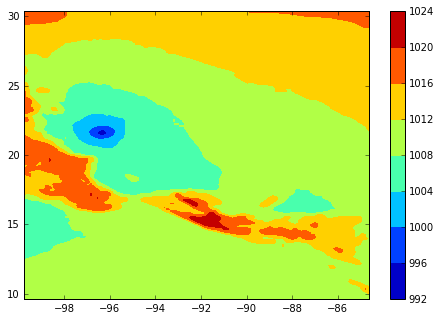

In [111]:
plt.contourf(wrf.variables['XLONG'][0][:,40:],wrf.variables['XLAT'][0][:,40:],p1[132][:,40:])
plt.colorbar()

In [93]:
wrfc=np.amin(p1,axis=(1,2))
operc=np.amin(ptt,axis=(1,2))
eraic=np.amin(pe,axis=(1,2))
hwrfc=np.amin(ph,axis=(1,2))

In [83]:
t=[]
for date in perdelta(sdate, edate+datetime.timedelta(hours=1), datetime.timedelta(hours=1)):
    t.append(date)
np.shape(t)

(241,)

In [84]:
wrfc.shape,operc.shape,eraic.shape,hwrfc.shape

((241,), (240,), (41,), (42,))

In [85]:
cdic={'time':t,'wrf':wrfc,'oper':operc}
edic={'time':t[::6], 'erai':eraic}
hdic={'time':th, 'hwrf':hwrfc}
df1=pd.DataFrame.from_dict(cdic, orient='index')

df2=pd.DataFrame.from_dict(edic)
df3=pd.DataFrame.from_dict(hdic)


In [86]:
df1 = df1.transpose()
df1 = df1.set_index(['time'])
df1.head()

,wrf,oper
time,,
2013-09-10 00:00:00,1006.22,1005.57
2013-09-10 01:00:00,1007.4,1006.54
2013-09-10 02:00:00,1007.59,1007.09
2013-09-10 03:00:00,1008.12,1007.94
2013-09-10 04:00:00,1008.29,1008.38


In [87]:
df2 = df2.set_index(['time'])

df2.head()

,erai
time,
2013-09-10 00:00:00,1006.134375
2013-09-10 06:00:00,1008.629375
2013-09-10 12:00:00,1008.339375
2013-09-10 18:00:00,1009.716250
2013-09-11 00:00:00,1006.713125


In [88]:
df3 = df3.set_index(['time'])

df3.head()

,hwrf
time,
2013-09-12 06:00:00,1005.777954
2013-09-12 09:00:00,1004.980164
2013-09-12 12:00:00,1003.565674
2013-09-12 15:00:00,1005.657166
2013-09-12 18:00:00,1002.708984


In [89]:
tot=pd.concat([df1,df2,df3],axis=1)

In [90]:
tot.head()

,wrf,oper,erai,hwrf
time,,,,
2013-09-10 00:00:00,1006.22,1005.57,1006.134375,NaN
2013-09-10 01:00:00,1007.4,1006.54,NaN,NaN
2013-09-10 02:00:00,1007.59,1007.09,NaN,NaN
2013-09-10 03:00:00,1008.12,1007.94,NaN,NaN
2013-09-10 04:00:00,1008.29,1008.38,NaN,NaN


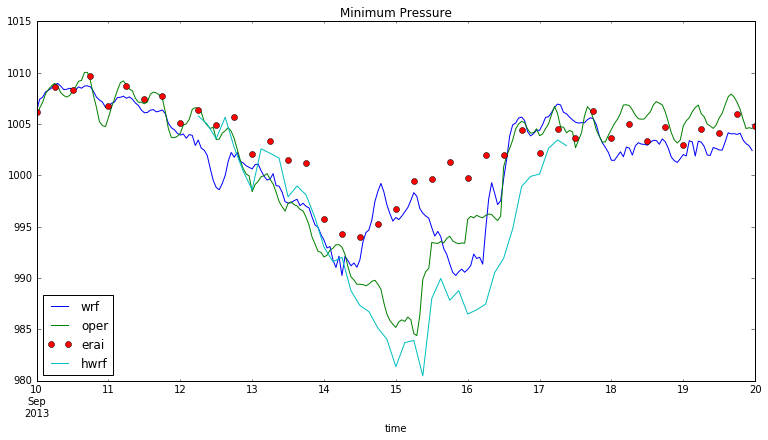

In [91]:
ax=tot[['wrf','oper']].dropna().plot(figsize=(10, 5))
tot['erai'].dropna().plot(ax=ax, linestyle='', marker='o')
tot['hwrf'].dropna().plot(ax=ax)
ax.legend(loc=0)
ax.set_title('Minimum Pressure')


## maximum wind track

In [60]:
w1=np.sqrt(u_wind_ms[:]**2+v_wind_ms[:]**2)
w2=np.sqrt(utt**2+vtt**2)
w3=np.sqrt(ue**2+ve**2)
w4=np.sqrt(uh**2+vh**2)

In [61]:
w1.max(),w2.max(),w3.max(),w4.max()

(38.990635, 31.531128608678735, 23.923493153621678, 39.121559)

In [112]:
wrfc=np.amax(w1[:,:,40:],axis=(1,2))
operc=np.amax(w2,axis=(1,2))
eraic=np.amax(w3,axis=(1,2))
hwrfc=np.amax(w4,axis=(1,2))

In [113]:
cdic={'time':t,'wrf':wrfc,'oper':operc}
edic={'time':t[::6], 'erai':eraic}
hdic={'time':th, 'hwrf':hwrfc}

df1=pd.DataFrame.from_dict(cdic, orient='index')
df2=pd.DataFrame.from_dict(edic)
df3=pd.DataFrame.from_dict(hdic)

df1 = df1.transpose()
df1 = df1.set_index(['time'])
df2 = df2.set_index(['time'])
df3 = df3.set_index(['time'])


In [114]:
totw=pd.concat([df1,df2,df3],axis=1)

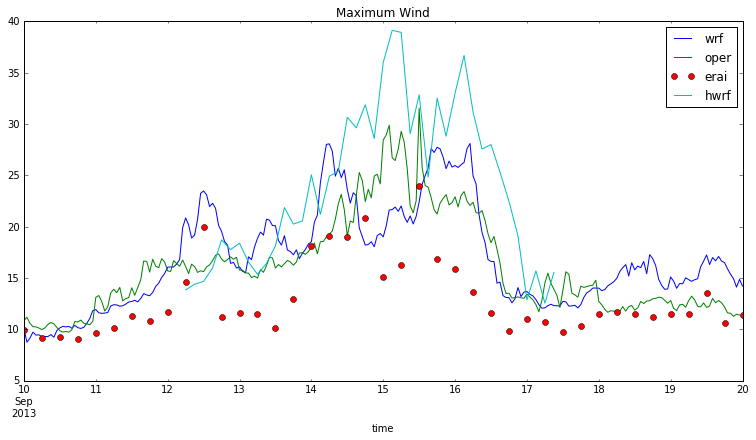

In [115]:
ax=totw[['wrf','oper']].plot(figsize=(10, 5))
totw['erai'].dropna().plot(ax=ax, linestyle='', marker='o')
totw['hwrf'].dropna().plot(ax=ax)

ax.legend(loc=0)
ax.set_title('Maximum Wind')